<a href="https://colab.research.google.com/github/Satinder83/AI_ML/blob/master/Recommendation_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Q1. Read and explore the given dataset. ( Rename column/add headers, plot histograms, find data characteristics)

In [ ]:
df= pd.read_csv('/content/drive/My Drive/Data/Electronic_dataset.csv' )

In [ ]:
df.head()

,user_id,prod_id,ratings,timestamp
0,A3L1GVWVJKWZZS,B0058UUR6E,5.0,1364774400
1,A08831071BVKZMKNCPI5S,B009ID0VVS,5.0,1357257600
2,A1SINU2I4IOPNU,B000GBO9IM,4.0,1358121600
3,A3P3P31EEOX2BD,B00CDCIOHO,3.0,1404950400
4,A3DBLJ3MPBJQMN,B000MS3VGA,5.0,1294444800


Renaming of columns is not required as they are self explanatory

### Data Characteristcs

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    500000 non-null  object 
 1   prod_id    500000 non-null  object 
 2   ratings    500000 non-null  float64
 3   timestamp  500000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 15.3+ MB


Database has 500K rows of data

Looking into unique count for Products and users

In [ ]:
len(df.prod_id.unique())

130138

In [ ]:
len(df.user_id.unique())

448368

There are 130k products dols across 448K unique users. Unique users are almost same in size as the database. Hence, it seems that number of repeat users are less.

I believe there is no need to change the column names and they are self explanatory. This is contrary to what is there in Question

Data Analysis

In [ ]:
df.prod_id.value_counts(ascending= False).head(10)

B0074BW614    1138
B00DR0PDNE    1094
B007WTAJTO     883
B0019EHU8G     774
B006GWO5WK     770
B003ELYQGG     765
B003ES5ZUU     681
B00622AG6S     668
B007R5YDYA     659
B008OHNZI0     589
Name: prod_id, dtype: int64

### Plotting

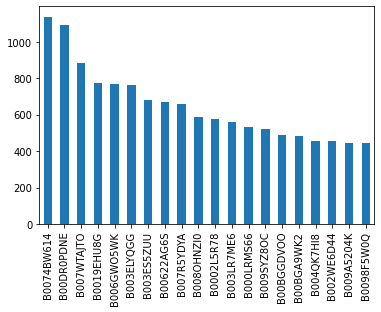

In [ ]:
df.prod_id.value_counts(ascending= False).head(20).plot(kind = 'bar')

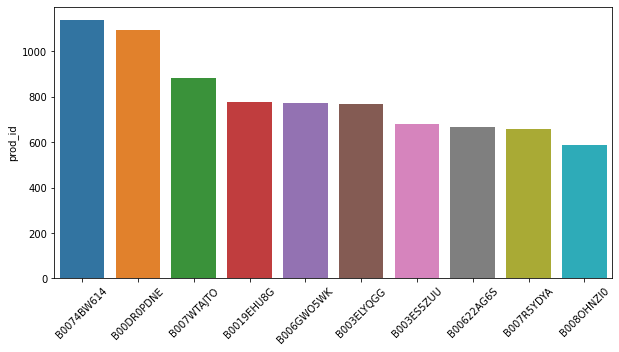

In [ ]:
plt.figure(figsize=(10,5))

chart = sns.barplot(x=df.prod_id.value_counts(ascending= False).head(10).index, y=df.prod_id.value_counts().head(10))
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

The above chart shows the barplot for top ten highest selling products

In [ ]:
df.groupby('prod_id')['ratings'].mean().head(20)

prod_id
0439886341    1.000000
0528881469    5.000000
0594012015    5.000000
0594033926    5.000000
0594451647    5.000000
0594481813    5.000000
0594514681    4.000000
0899336795    1.000000
0970407998    5.000000
0970408005    4.000000
0972683275    4.741379
0979526191    3.000000
1034385789    2.000000
1394860919    3.750000
1400501466    3.681818
1400501520    5.000000
1400501741    5.000000
1400501776    3.333333
1400532620    2.500000
1400532655    4.272727
Name: ratings, dtype: float64

Calculating mean product rating and displaying first 20

In [ ]:
df.groupby('prod_id')['ratings'].count().sort_values(ascending= False).head(20)

prod_id
B0074BW614    1138
B00DR0PDNE    1094
B007WTAJTO     883
B0019EHU8G     774
B006GWO5WK     770
B003ELYQGG     765
B003ES5ZUU     681
B00622AG6S     668
B007R5YDYA     659
B008OHNZI0     589
B0002L5R78     575
B003LR7ME6     562
B000LRMS66     534
B009SYZ8OC     519
B00BGGDVOO     491
B00BGA9WK2     483
B004QK7HI8     455
B002WE6D44     454
B009A5204K     444
B0098F5W0Q     443
Name: ratings, dtype: int64


# Q2 Polularity Based Recommendation Model

The objective is to recommend products based on the popularity, and start ratings does indicate the more popular products

In [ ]:
mean_ratings_count = pd.DataFrame(df.groupby('prod_id')['ratings'].mean())

In [ ]:
mean_ratings_count.head(10)

,ratings
prod_id,
0439886341,1.0
0528881469,5.0
0594012015,5.0
0594033926,5.0
0594451647,5.0
0594481813,5.0
0594514681,4.0
0899336795,1.0
0970407998,5.0


In [ ]:
mean_ratings_count['rating_count'] = pd.DataFrame(df.groupby('prod_id')['ratings'].count())

In [ ]:
mean_ratings_count.head().sort_values(by= 'rating_count', ascending= True)

,ratings,rating_count
prod_id,,
0439886341,1.0,1
0528881469,5.0,1
0594012015,5.0,1
0594033926,5.0,1
0594451647,5.0,1


In [ ]:
mean_ratings_count.ratings.value_counts(normalize= True, ascending= False).head()

5.0    0.365796
4.0    0.148212
3.0    0.083949
1.0    0.082889
2.0    0.044630
Name: ratings, dtype: float64

It so appears that 36% of products sold have mean rating of 5

## Q4 Collaborative Filtering Model

In [ ]:
!pip install surprise

In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise.model_selection import cross_validate
from collections import defaultdict

System Crashing because of Limited Ram, hence limiting datasize

In [ ]:
df= pd.read_csv('/content/drive/My Drive/Data/Electronic_dataset.csv' )

df1 = df.drop('timestamp', axis= 1)


Data size limited to 4% as current available ram in Colab was insufficinet to run 100% or even 10%

In [ ]:
df1_sample = df1.sample(frac = 0.04)
df1_sample.shape

(20000, 3)

In [ ]:
reader = Reader(rating_scale=(1,5))

data = Dataset.load_from_df(df1_sample, reader)

In [ ]:
data

Q3 Splitting Data

In [ ]:
trainset, testset = train_test_split(data, test_size=.3, random_state= 7)

Collaborative Model

In [ ]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
test_pred = algo.test(testset)

In [ ]:
test_pred

[Prediction(uid='A8IBQYVDIQEVK', iid='B008G2GBN4', r_ui=5.0, est=4.005714285714285, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AS2X2ZX25LVXI', iid='B002CVTKII', r_ui=5.0, est=4.005714285714285, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2NNK8Y57I7LOF', iid='B001UHO7A6', r_ui=2.0, est=4.005714285714285, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1IB3Z4S24Q0RH', iid='B00A6HH28U', r_ui=4.0, est=4.005714285714285, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AU8ZI6RIWWAY0', iid='B003HFCDLY', r_ui=2.0, est=4.005714285714285, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2JL9UGPDCRAP1', iid='B005N8A4Z0', r_ui=5.0, est=4.005714285714285, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A224H2V0NBVPF'

In [ ]:
uid = str('ADSZRRKKOG4FN')
iid = str('B008THTWIW')

In [ ]:
pred = algo.predict(uid, iid, r_ui=4, verbose=True)
pred

user: ADSZRRKKOG4FN item: B008THTWIW r_ui = 4.00   est = 4.01   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='ADSZRRKKOG4FN', iid='B008THTWIW', r_ui=4, est=4.005714285714285, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

Q5. Evaluate the above model and Alternate to RMSE

In [ ]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)
``

User-based Model : Test Set
RMSE: 1.3830


1.3830298672138075

Alternate to RMSE, MAE (Mean Absolute Error)

In [ ]:
accuracy.mae(test_pred, verbose=True)

MAE:  1.1009


1.1009485714285714

## Q6. Get top - K ( K = 5) recommendations

In [ ]:
def get_top_n(pred, n=5):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in pred:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
top_n = get_top_n(test_pred, n=5)

In [ ]:
len(top_n)

5983

In [ ]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

Streaming output truncated to the last 5000 lines.
A3K0YCRM6SW4HX ['B000EWTBS6']
A3QP11YS380Q2Z ['B002LZ4DCS']
A1FTX8DNLS2WBK ['B002XFFHBM']
A1DBVSOFMC45A9 ['B00427ZLRO']
A3E00OVWBMCIKL ['B002RL875A']
A2FGLCLVGZ4TWE ['B007TB0PIA']
A1IXU3B3HN0PMN ['B004X4TIJS']
A258ROI8H9XC5K ['B001N2MUD4']
A1NWR3WTBMSCU1 ['B006ZP8UOW']
A25AGA4P5XWHVQ ['B0000AJMOI']
A3N83CTIZPI23H ['B0098FKH9C']
A19QGRTZZ6DR3G ['B0035AN31A']
A3QV1CVET4NA1I ['B0077QVOV4']
A3G2THGBOT3S7T ['B000I3AGWQ']
A1XP4HYNRWP2Q9 ['B000ET97CY']
A178D2M8H37E2M ['B003ZSP0WW']
AKATXRHJBI4G9 ['B007B31IAK']
A2AGITLSHQYCSU ['B0009RGLSE']
A1CRH7USAATK7W ['B004HCO9UY']
A2ND4JZSYTJIYT ['B0048IATQ0']
ATS8X3L2Z4WJE ['B009N06CVY']
A3EI1QNYTB8W99 ['B004NOVLTI']
A3M3ITE2YFQS6Z ['B0006238YM']
A1BHTB2I53RRP ['B001EWEXOC']
A2KGQJWZ5HES4M ['B00466ZAOA']
A2J9WN7O7QZT0Y ['B00CMQTVK0']
A2HJ0BQMAPWP1V ['B008NMCPTQ']
A2K2NVVGK67HB ['B000LRMS66']
A3ME2UCJ9X1NVB ['B004OB0EBQ']
A3HVX1Q10UBL3B ['B003U51XIU']
A158R7U24SFS1T ['B0016P48UQ']
ACJILK2JMP2S4 ['B00126V

Checking Precision and Recall

In [ ]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls



In [ ]:
precisions, recalls = precision_recall_at_k(test_pred, k=5, threshold=4)

In [ ]:
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.751211766672238
0.7519638977101788


## 7. Summarise your insights.

So overall, we are able to predict by 75% recall and precision and recall rate for the model, so this is good and can be used for production. based on the Ratings given by the user, we are able to recommend new products to users and can significantly improve sales for Electronics

Further, by working around hyperparamters and using better models like SVD this can be improved further. 